In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

Pkg.add("Revise")
using Revise

using Pun
using Plots

  Activating project at `~/Documents/code/Pun.jl`
Precompiling project...
    186.8 ms  ? Pun
   Resolving package versions...
      Compat entries added for 
  No Changes to `~/Documents/code/Pun.jl/Project.toml`
  No Changes to `~/Documents/code/Pun.jl/Manifest.toml`
Precompiling project...
    117.5 ms  ? Pun
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
include("examples.jl")

rejection (generic function with 1 method)

# Basic example from base measure paper

In [88]:
# Sample points from a uniform on a circle

circle_dist(r) = @prob begin
    theta <<= uniform(0, pi/2)
    point <<= dirac((r*cos(theta), r*sin(theta)))
    theta >>= dirac(atan(point[2]/r, point[1]/r))
    return point
end

squashed_circle_dist(r) = @prob begin
    point <<= circle_dist(r)
    squashed_point .<<= (point[1] * 2., point[2] * 20.)

    # Note - if you don't include this unnassignment, you'll get an error! (as expected)
    point .>>= (squashed_point[1] / 2., squashed_point[2] / 20.)
    return squashed_point
end

function simulate_and_plot(N:: Integer, p)
    x, y, log_densities = [], [], []
    for _ in 1:N
        point, log_density = simulate(p)
        push!(log_densities, log_density)
        push!(x, point[1].value)
        push!(y, point[2].value)
    end
    eps = 1e-4
    min_density, max_density = minimum(log_densities) - eps, maximum(log_densities) + eps
    minmax_densities = map(x -> (x - min_density) / (max_density - min_density), log_densities)
    cmap = cgrad(:viridis)
    colors = map(x -> cmap[x], minmax_densities)
    return plot(x, y, seriestype=:scatter, c=colors, aspect_ratio=1), x, y, log_densities
end


simulate_and_plot (generic function with 1 method)

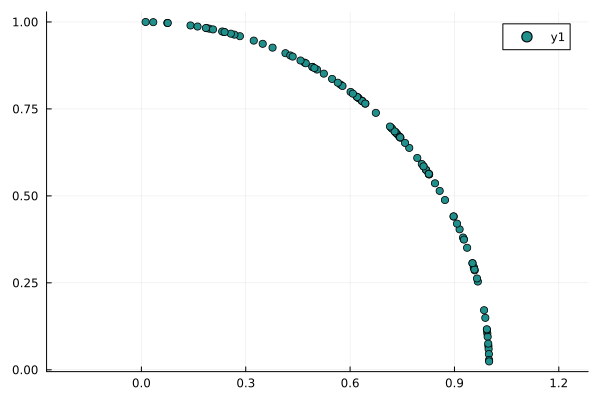

In [89]:
# Note the density here is pi / 2 (as expected!)

fig, x, y, log_densities = simulate_and_plot(100, circle_dist(1.))
fig

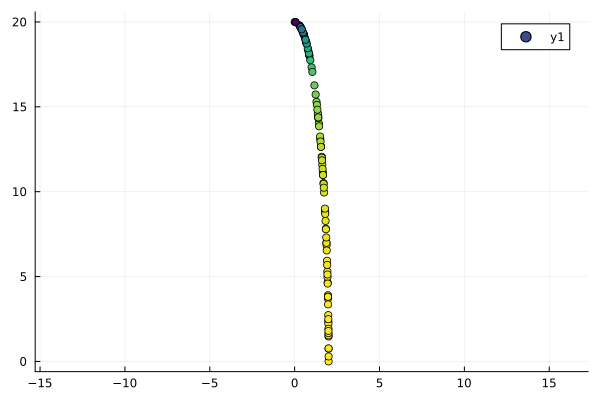

In [90]:
fig, x, y, densities = simulate_and_plot(100, squashed_circle_dist(1.))
fig

# Example passing result of one computation to another

In [ ]:
diagonal = @prob begin
    u <<= random()
    return (u, u)
end

point, log_d = simulate(diagonal)

print("density ", exp(log_d), " approx eq. to sqrt(2) = ", sqrt(2))

density 1.4142135623730951 approx eq. to sqrt(2) = 1.4142135623730951

density 4.999999999999999 approx eq. to sqrt(3^2 + 4^2) = 5

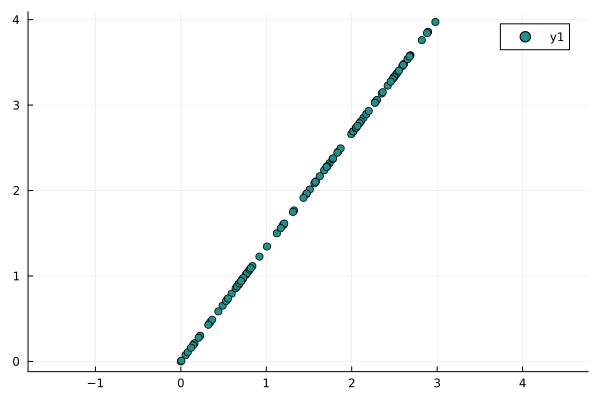

In [117]:
stretched_diagonal(w, h) = @prob begin
    u <<= random()
    x .<<= w * u
    y .<<= h * u
    u .>>= x / w
    return (x, y)
end

fig, x, y, log_d = simulate_and_plot(100, stretched_diagonal(3, 4))

print("density ", exp(log_d[1]), " approx eq. to sqrt(3^2 + 4^2) = 5")
fig

# Example of something where the current jacobian correction is extremely slow to compute (or doesn't work)

# More interesting example of sampling from manifold-supported distribution